# Predicting Heart Disease: DSCI 100 Group Project Report  (Group 23)

### Introduction:

Cardiovascular diseases (CVDs), or heart diseases, encompasses a range of medical conditions that affect the heart and blood vessels. Worldwide, CVDs are the leading cause of death with nearly 18 million deaths a year (World Health Organization, 2023). Early detection is key to treatment, prevention, and management of heart disease; our data analysis aims to help with this. 

The dataset used is from: https://archive.ics.uci.edu/dataset/45/heart+disease. The data was published in 1988 and the dataset we are using is the one specifically collected in Cleveland. The dataset consists of 303 observations and 14 variables.

The question we aim to address is: **can we predict if a patient has heart disease based on their age, resting blood pressure, serum cholesterol, and maximum resting heart rate?**

In [1]:
library(tidyverse)
library(RColorBrewer)
library(tidymodels)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
#These lines of code bring the data into R and make it into a table showing the first 15 rows
download.file("https://raw.githubusercontent.com/Aamitoz-Sharma/Group_23_project/main/heart.csv", "heart_data.csv") #downloading file
heart_data <- read_csv("heart_data.csv")
head(heart_data)


Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0


In [3]:
set.seed(1) #setting seed to make the code reproducible

#This set of data will select the data points we are interested in Age, Resting blood pressure, Cholesterol, Max heart rate and Heart Disease
heart <- heart_data |> 
    select(Age, RestingBP, Cholesterol, MaxHR, HeartDisease) |>
#This line changes the Heart Disease variable from a continous quantitative variable(dbl) to a categorical variable(fct)
    mutate(HeartDisease = as_factor(HeartDisease)) |>
#This line changes the factor variables from 0 to no and 1 to yes
    mutate(HeartDisease = fct_recode(HeartDisease, "yes" = "1", "no" = "0")) 
head(heart)

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,140,289,172,no
49,160,180,156,yes
37,130,283,98,no
48,138,214,108,yes
54,150,195,122,no
39,120,339,170,no


In [4]:
#splitting into training and testing data as this allows us to know how good our model is and if it is making any mistakes
heart_split <- initial_split(heart, prop = 0.75, strata = HeartDisease) #splitting into training and testing data.
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

head(heart_train)
head(heart_test)

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,140,289,172,no
37,130,283,98,no
54,150,195,122,no
39,120,339,170,no
43,120,201,165,no
43,100,223,142,no


Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
45,130,237,170,no
54,110,208,142,no
48,120,284,120,no
37,130,211,142,no
39,120,204,145,no
42,115,211,137,no


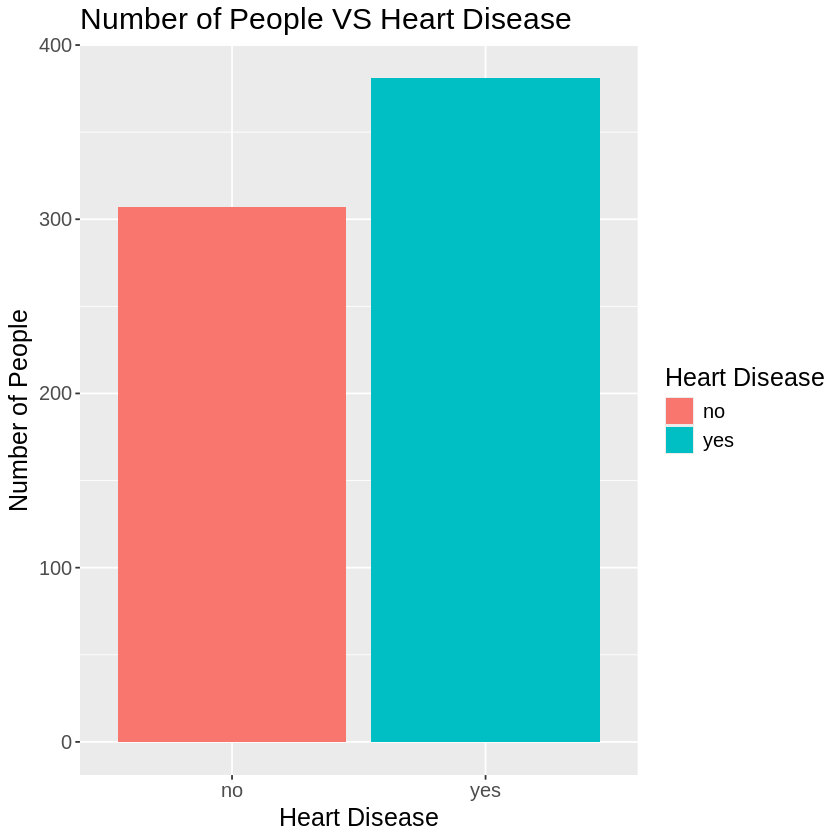

In [34]:
options(repr.plot.width = 7, repr.plot.height = 7) 
heart_disease_plot <- heart_train |>
    ggplot(aes(x = HeartDisease, fill = HeartDisease)) +
    geom_bar() +
    xlab("Heart Disease") +
    ylab("Number of People") +
    labs(fill = "Heart Disease") +
    ggtitle("Number of People VS Heart Disease") +
    theme(text = element_text(size = 15))

heart_disease_plot

In [5]:
# Finding the best k for predicting heart disease using Age and Resting Blood pressure as predictors
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_vfold <- vfold_cv(heart_train, v = 10, strata = HeartDisease)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

heart_recipe_Age_RestingBP <- recipe(HeartDisease ~ Age + RestingBP,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

Age_RestingBP_best_k <- workflow() |>
    add_recipe(heart_recipe_Age_RestingBP) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
Age_RestingBP_best_k

[1] 96

In [6]:
# Finding the best k for predicting heart disease using Age and Cholesterol as predictors
heart_recipe_Age_Cholesterol <- recipe(HeartDisease ~ Age + Cholesterol,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

Age_Cholesterol_best_k <- workflow() |>
    add_recipe(heart_recipe_Age_Cholesterol) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
Age_Cholesterol_best_k

[1] 51

In [7]:
# Finding the best k for predicting heart disease using Age and MaxHR as predictors
heart_recipe_Age_MaxHR <- recipe(HeartDisease ~ Age + MaxHR,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

Age_MaxHR_best_k <- workflow() |>
    add_recipe(heart_recipe_Age_MaxHR) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
Age_MaxHR_best_k 

[1] 56

In [8]:
# Finding the best k for predicting heart disease using MaxHR and Cholesterol as predictors
heart_recipe_MaxHR_Cholesterol <- recipe(HeartDisease ~ MaxHR + Cholesterol,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

MaxHR_Cholesterol_best_k <- workflow() |>
    add_recipe(heart_recipe_MaxHR_Cholesterol) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
MaxHR_Cholesterol_best_k 

[1] 61

In [9]:
# Finding the best k for predicting heart disease using MaxHR and RestingBP
heart_recipe_RestingBP_MaxHR <- recipe(HeartDisease ~ MaxHR + RestingBP,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

RestingBP_MaxHR_best_k <- workflow() |>
    add_recipe(heart_recipe_RestingBP_MaxHR) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
RestingBP_MaxHR_best_k 

[1] 46

In [10]:
# Finding the best k for predicting heart disease using Cholesterol and RestingBP as predictors
heart_recipe_RestingBP_Cholesterol <- recipe(HeartDisease ~ Cholesterol + RestingBP,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

RestingBP_Cholesterol_best_k <- workflow() |>
    add_recipe(heart_recipe_RestingBP_Cholesterol) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
RestingBP_Cholesterol_best_k 

[1] 96

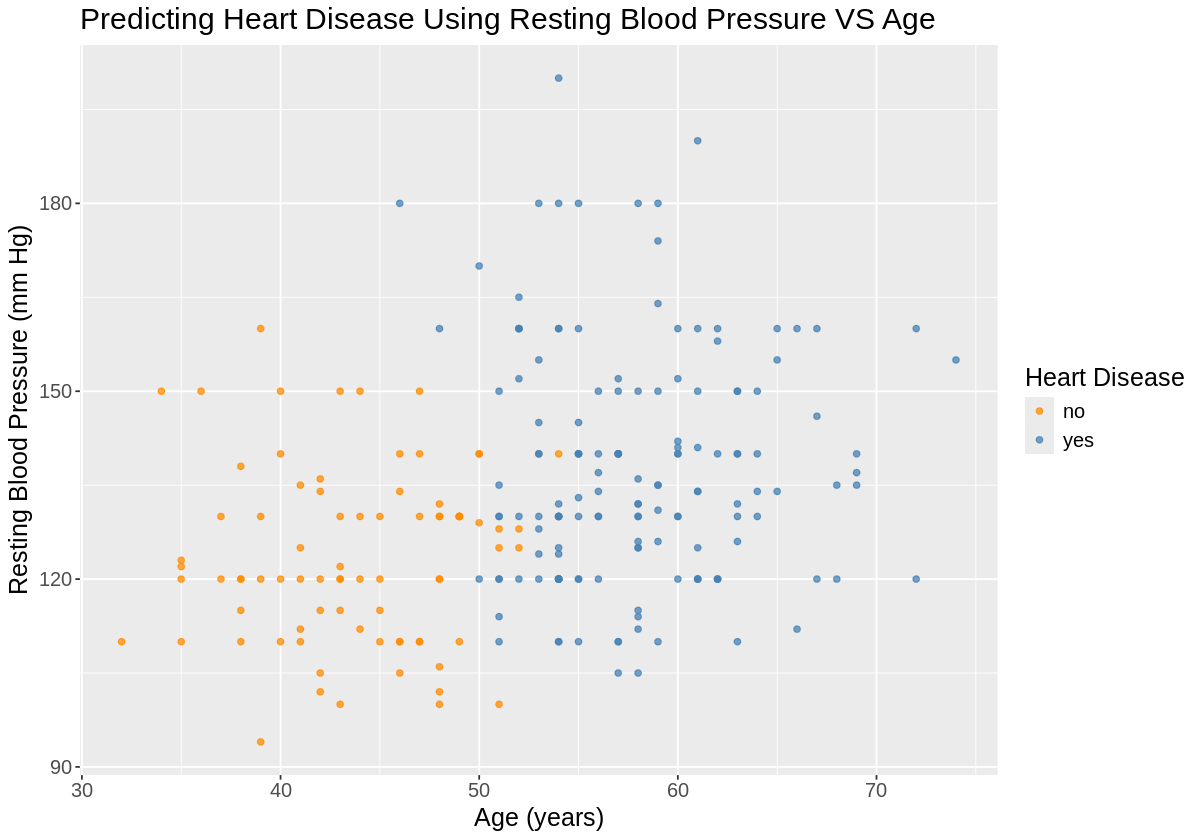

In [50]:
options(repr.plot.width = 10, repr.plot.height = 7) 
heart_spec_Age_RestingBP <- nearest_neighbor(weight_func = "rectangular", neighbors = Age_RestingBP_best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit_Age_RestingBP <- workflow() |>
        add_recipe(heart_recipe_Age_RestingBP) |>
        add_model(heart_spec_Age_RestingBP) |>
        fit(data = heart_train)

Heart_preds_Age_RestingBP <- heart_fit_Age_RestingBP |>
        predict(heart_test) |>
        bind_cols(heart_test)

heart_plot_Age_RestingBP <- ggplot() +
  geom_point(data = Heart_preds_Age_RestingBP,
             mapping = aes(x = Age,
                           y = RestingBP,
                           color = .pred_class),
             alpha = 0.75) +
  labs(color = "Heart Disease",
       x = "Age (years)",
       y = "Resting Blood Pressure (mm Hg)") +
  ggtitle("Predicting Heart Disease Using Resting Blood Pressure VS Age") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 15))

heart_plot_Age_RestingBP

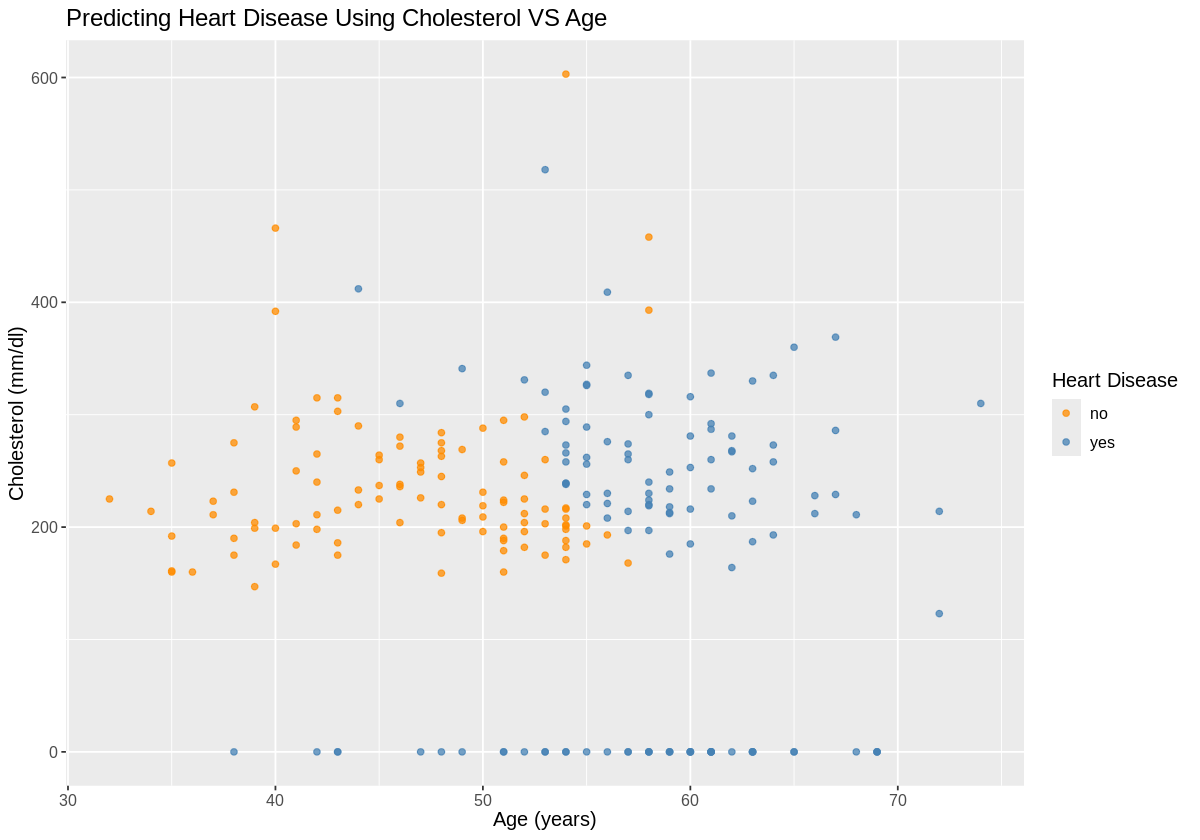

In [52]:
options(repr.plot.width = 10, repr.plot.height = 7) 
heart_spec_Age_Cholesterol <- nearest_neighbor(weight_func = "rectangular", neighbors = Age_Cholesterol_best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit_Age_Cholesterol <- workflow() |>
        add_recipe(heart_recipe_Age_Cholesterol) |>
        add_model(heart_spec_Age_Cholesterol) |>
        fit(data = heart_train)

Heart_preds_Age_Cholesterol <- heart_fit_Age_Cholesterol |>
        predict(heart_test) |>
        bind_cols(heart_test)

heart_plot_Age_Cholesterol <- ggplot() +
  geom_point(data = Heart_preds_Age_Cholesterol,
             mapping = aes(x = Age,
                           y = Cholesterol,
                           color = .pred_class),
             alpha = 0.75) +
  labs(color = "Heart Disease",
       x = "Age (years)",
       y = "Cholesterol (mm/dl)") +
  ggtitle("Predicting Heart Disease Using Cholesterol VS Age") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

heart_plot_Age_Cholesterol

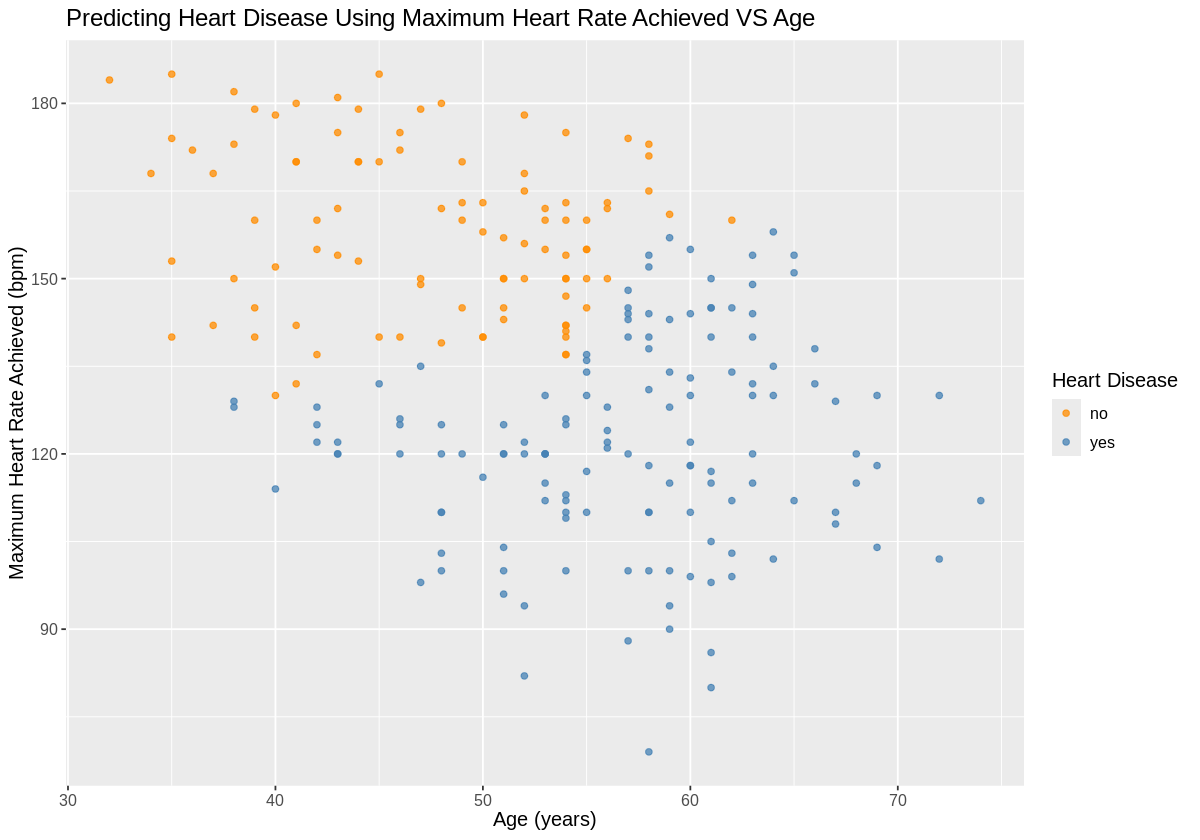

In [51]:
options(repr.plot.width = 10, repr.plot.height = 7) 
heart_spec_Age_MaxHR <- nearest_neighbor(weight_func = "rectangular", neighbors = Age_MaxHR_best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit_Age_MaxHR <- workflow() |>
        add_recipe(heart_recipe_Age_MaxHR) |>
        add_model(heart_spec_Age_MaxHR) |>
        fit(data = heart_train)

Heart_preds_Age_MaxHR <- heart_fit_Age_MaxHR |>
        predict(heart_test) |>
        bind_cols(heart_test)

heart_plot_Age_MaxHR <- ggplot() +
  geom_point(data = Heart_preds_Age_MaxHR,
             mapping = aes(x = Age,
                           y = MaxHR,
                           color = .pred_class),
             alpha = 0.75) +
  labs(color = "Heart Disease",
       x = "Age (years)",
       y = "Maximum Heart Rate Achieved (bpm)") +
  ggtitle("Predicting Heart Disease Using Maximum Heart Rate Achieved VS Age") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

heart_plot_Age_MaxHR

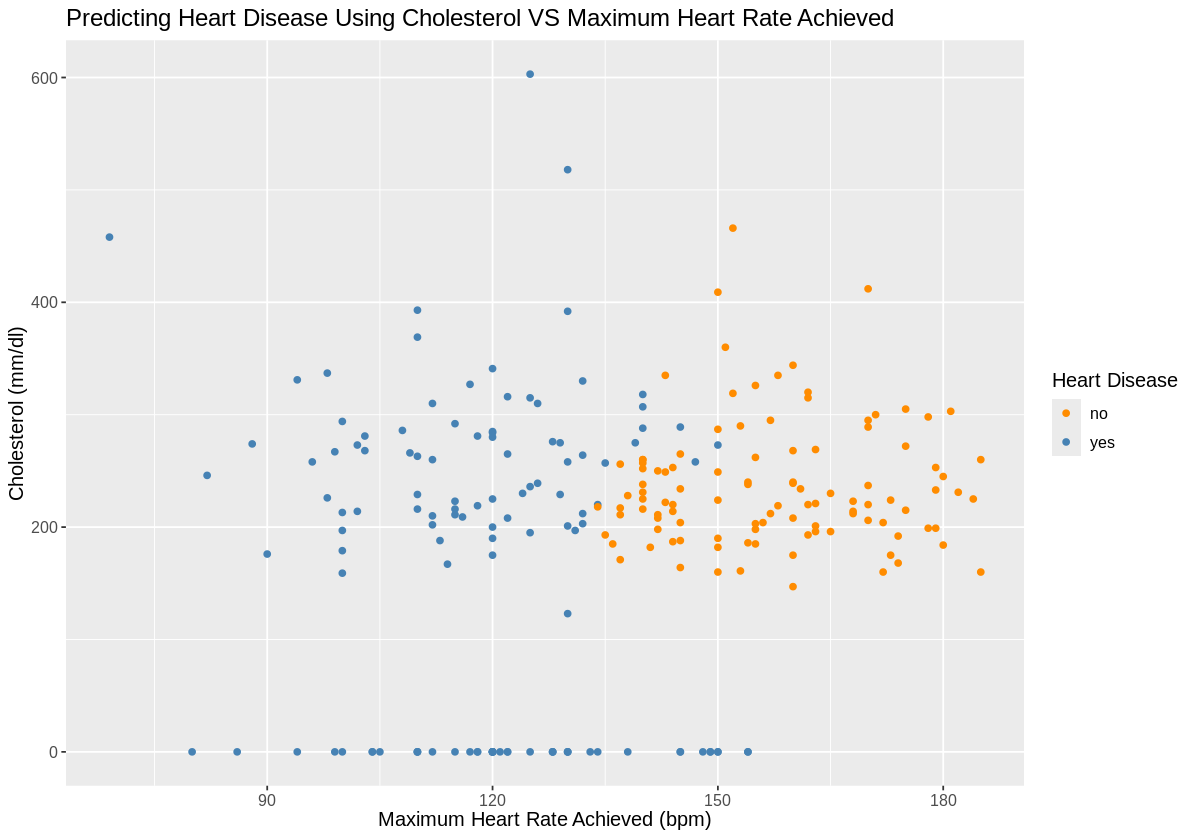

In [53]:
options(repr.plot.width = 10, repr.plot.height = 7) 
heart_spec_MaxHR_Cholesterol <- nearest_neighbor(weight_func = "rectangular", neighbors = MaxHR_Cholesterol_best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit_Age_MaxHR <- workflow() |>
        add_recipe(heart_recipe_MaxHR_Cholesterol) |>
        add_model(heart_spec_MaxHR_Cholesterol) |>
        fit(data = heart_train)

Heart_preds_MaxHR_Cholesterol <- heart_fit_Age_MaxHR |>
        predict(heart_test) |>
        bind_cols(heart_test)

heart_plot_MaxHR_Cholesterol <- ggplot() +
  geom_point(data = Heart_preds_MaxHR_Cholesterol,
             mapping = aes(x = MaxHR,
                           y = Cholesterol,
                           color = .pred_class)) +
  labs(color = "Heart Disease",
       x = "Maximum Heart Rate Achieved (bpm)",
       y = "Cholesterol (mm/dl)") +
  ggtitle("Predicting Heart Disease Using Cholesterol VS Maximum Heart Rate Achieved") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

heart_plot_MaxHR_Cholesterol

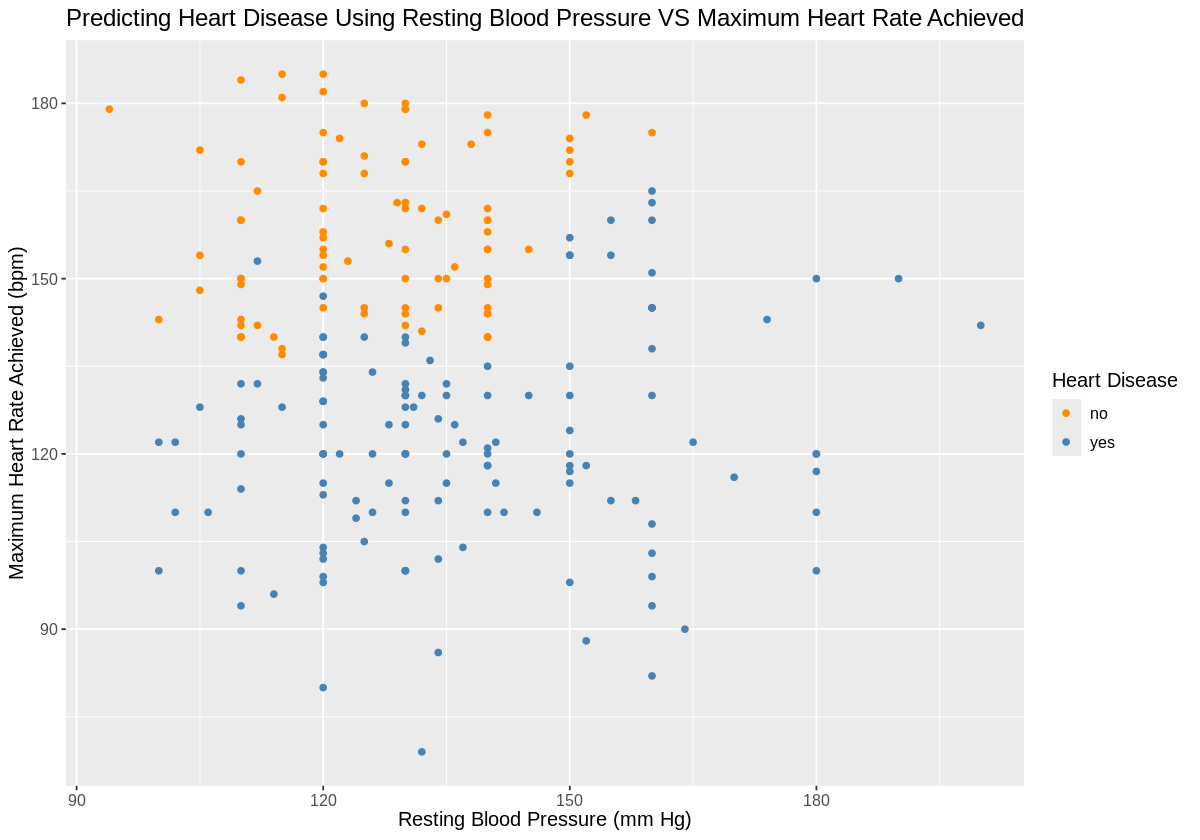

In [54]:
options(repr.plot.width = 10, repr.plot.height = 7) 
heart_spec_RestingBP_MaxHR <- nearest_neighbor(weight_func = "rectangular", neighbors = RestingBP_MaxHR_best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit_RestingBP_MaxHR <- workflow() |>
        add_recipe(heart_recipe_RestingBP_MaxHR) |>
        add_model(heart_spec_RestingBP_MaxHR) |>
        fit(data = heart_train)

Heart_preds_RestingBP_MaxHR <- heart_fit_RestingBP_MaxHR |>
        predict(heart_test) |>
        bind_cols(heart_test)

heart_plot_RestingBP_MaxHR <- ggplot() +
  geom_point(data = Heart_preds_RestingBP_MaxHR,
             mapping = aes(x = RestingBP,
                           y = MaxHR,
                           color = .pred_class)) +
  labs(color = "Heart Disease",
       x = "Resting Blood Pressure (mm Hg)",
       y = "Maximum Heart Rate Achieved (bpm)") +
  ggtitle("Predicting Heart Disease Using Resting Blood Pressure VS Maximum Heart Rate Achieved") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

heart_plot_RestingBP_MaxHR

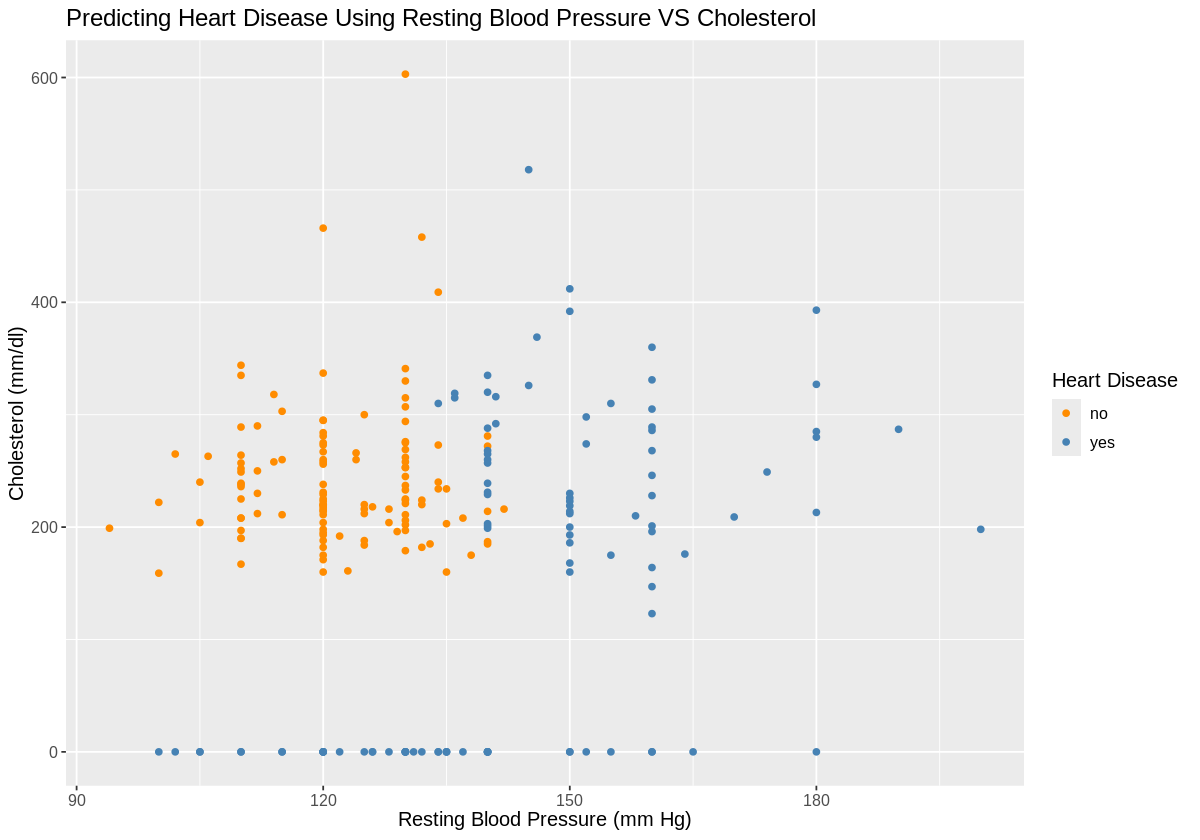

In [55]:
options(repr.plot.width = 10, repr.plot.height = 7) 
heart_spec_RestingBP_Cholesterol <- nearest_neighbor(weight_func = "rectangular", neighbors = RestingBP_Cholesterol_best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit_RestingBP_Cholesterol <- workflow() |>
        add_recipe(heart_recipe_RestingBP_Cholesterol) |>
        add_model(heart_spec_RestingBP_Cholesterol) |>
        fit(data = heart_train)

Heart_preds_RestingBP_Cholesterol <- heart_fit_RestingBP_Cholesterol |>
        predict(heart_test) |>
        bind_cols(heart_test)

heart_plot_RestingBP_Cholesterol <- ggplot() +
  geom_point(data = Heart_preds_RestingBP_Cholesterol,
             mapping = aes(x = RestingBP,
                           y = Cholesterol,
                           color = .pred_class)) +
  labs(color = "Heart Disease",
       x = "Resting Blood Pressure (mm Hg)",
       y = "Cholesterol (mm/dl)") +
  ggtitle("Predicting Heart Disease Using Resting Blood Pressure VS Cholesterol") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))
heart_plot_RestingBP_Cholesterol